# Setup

In [43]:
using Plots
using LinearAlgebra
using DelimitedFiles
using DataFrames
using CSV

In [44]:
raw_traj = DataFrame(CSV.File("nand-logs/log57-gps.csv"))

992×4 DataFrame
 Row │ timestamp  pos_x      pos_y           acc     
     │ Int64      Float64    Float64         Float64 
─────┼───────────────────────────────────────────────
   1 │     49945  4.47739e6  589579.0           14.1
   2 │     50046  4.47739e6  589579.0           14.1
   3 │     50149  4.47739e6  589579.0           14.1
   4 │     50249  4.47739e6  589579.0           14.1
   5 │     50351  4.47739e6  589579.0           14.1
   6 │     50454  4.47739e6  589579.0           14.1
   7 │     50554  4.47739e6  589579.0           14.1
   8 │     50656  4.47739e6  589579.0           14.1
  ⋮  │     ⋮          ⋮            ⋮            ⋮
 986 │    152000  4.47747e6       5.8967e5    1819.5
 987 │    152101  4.47747e6  589670.0         1828.5
 988 │    152202  4.47747e6       5.8967e5    1836.6
 989 │    152304  4.47747e6       5.8967e5    1847.4
 990 │    152407  4.47747e6       5.8967e5    1851.6
 991 │    152508  4.47747e6       5.89671e5   1859.4
 992 │    152615  4.47747e6       5.89671e5   1866.7
                                     977 rows omitted

# Trial 1 - Has Bugs
```
state_cov_matrix_t curr_state_cov{{1, 0, 0},
                                  {0, 1, 0},
                                  {0, 0, 1}};
state_cov_matrix_t process_noise{{0.0001, 0, 0},
                                  {0, 0.0001, 0},
                                  {0, 0, 0.000001}};
```

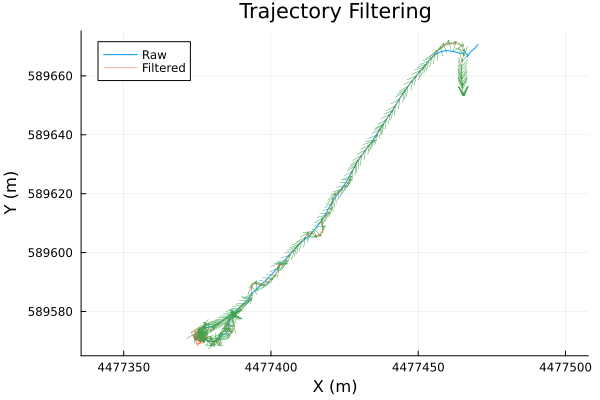

In [58]:
filter_traj_trial1 = DataFrame(CSV.File("nand-logs/log57-filter.csv"))

plot(title="Trajectory Filtering", xlabel="X (m)", ylabel="Y (m)", aspect_ratio=:equal)
plot!(raw_traj[:, "pos_x"], raw_traj[:, "pos_y"], label="Raw")
plot!(filter_traj_trial1[3:end, "pos_x"], filter_traj_trial1[3:end, "pos_y"], label="Filtered", linewidth=0.5)
quiver!(filter_traj_trial1[3:50:end, "pos_x"], filter_traj_trial1[3:50:end, "pos_y"], quiver=(cos.(filter_traj_trial1[3:50:end, "heading"]), sin.(filter_traj_trial1[3:50:end, "heading"])), label="Filtered", linewidth=0.5)


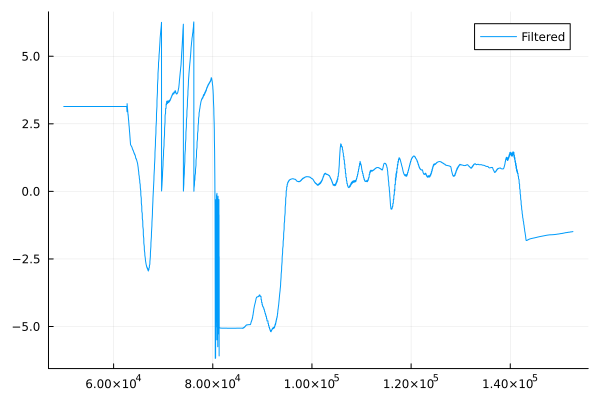

In [50]:
plot(filter_traj_trial1[:, "timestamp"], filter_traj_trial1[:, "heading"], label="Filtered")

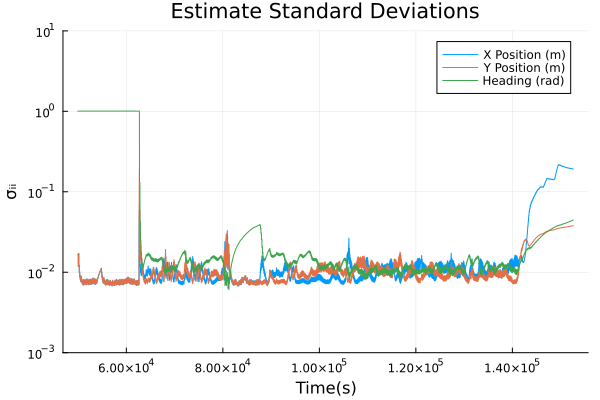

In [60]:
cov_trial1 = DataFrame(CSV.File("nand-logs/log57-covar-fixed.csv"))
timestamps = cov_trial1[:, "timestamp"]

vel = DataFrame(CSV.File("nand-logs/log57-encoder.csv"))

plot(title="Estimate Standard Deviations", xlabel="Time(s)", ylabel="σᵢᵢ", yscale=:log10, ylim=(1e-3, 10))
plot!(timestamps, sqrt.(cov_trial1[:, "c1"]), label="X Position (m)")
plot!(timestamps, sqrt.(cov_trial1[:, "c5"]), label="Y Position (m)")
plot!(timestamps, sqrt.(cov_trial1[:, "c9"]), label="Heading (rad)")
plot!(timestamps, vel[:, "speed"], label="Speed")

# Trial 2 - Better
Tuning matricies are the same as Trial 1
```
state_cov_matrix_t curr_state_cov{{1, 0, 0},
                                  {0, 1, 0},
                                  {0, 0, 1}};
state_cov_matrix_t process_noise{{0.0001, 0, 0},
                                  {0, 0.0001, 0},
                                  {0, 0, 0.000001}};
```
The difference here is that the UKF was run with skipping timesteps where velocity = 0.

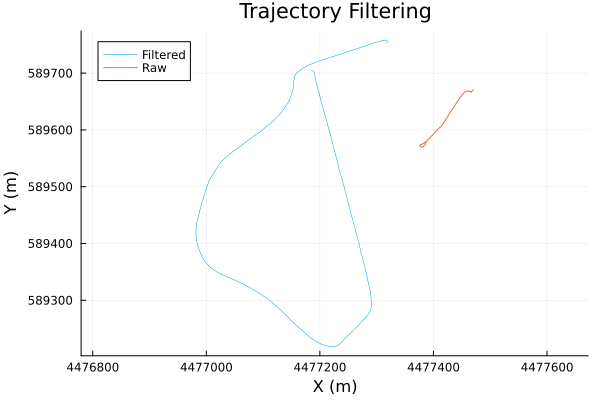

In [47]:
filter_traj_trial2 = DataFrame(CSV.File("trials/filter-trial2.csv"))

plot(title="Trajectory Filtering", xlabel="X (m)", ylabel="Y (m)", aspect_ratio=:equal)
plot!(filter_traj_trial2[3:end, "pos_x"], filter_traj_trial2[3:end, "pos_y"], label="Filtered", linewidth=0.5)
plot!(raw_traj[:, "pos_x"], raw_traj[:, "pos_y"], label="Raw")

In [48]:
plot(title="Raw-Filtered Difference", xlabel="", ylabel="|Raw - Filtered| (m)")
plot!([norm(x[1:2] - xhat[1:2]) for (xhat,x) in zip(Xhat, X)], label="Time (s)")
plot!([norm(x[1:2] - [px; py]) for (px,py,x) in zip(px, py, X)], label="Filtered (Teensy)")

UndefVarError: UndefVarError: `Xhat` not defined

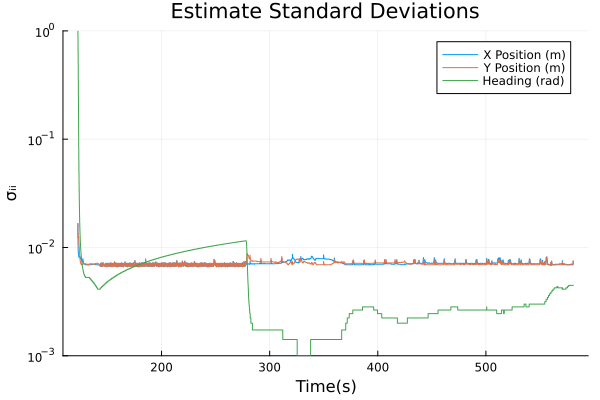

In [49]:
cov_trial2 = DataFrame(CSV.File("trials/covariance-trial2.csv"))
timestamps = cov_trial2[:, "timestamp"]

plot(title="Estimate Standard Deviations", xlabel="Time(s)", ylabel="σᵢᵢ", yscale=:log10, ylim=(1e-3, 1))
plot!(timestamps, sqrt.(cov_trial2[:, "c1"]), label="X Position (m)")
plot!(timestamps, sqrt.(cov_trial2[:, "c5"]), label="Y Position (m)")
plot!(timestamps, sqrt.(cov_trial2[:, "c9"]), label="Heading (rad)")